# Datos descargados de: https://www.pmel.noaa.gov/tao/drupal/disdel/



---


# PERFIL VERTICAL DE "ANOMALÍA DE TEMPERATURA SUB SUPERFICIAL DEL MAR" DE LA BOYA UBICADA EN 0N - 170W

---



In [105]:
# Conectando google drive con colab:
#-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
#-------------------------------------
import os
path = '/content/drive/MyDrive/Colab Notebooks/OCEANOGRAFIA/BOYA 0N170W/' # Ruta del directorio de trabajo
os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [106]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [107]:
ds = xr.open_dataset(path + 't0n170w_dy.cdf',
                       drop_variables = ['time_bnds','ST_6020','QT_5020','ZSST_2003','depzsst']) # Eliminamos variable inservibles.
ds['time'] = pd.date_range('1988-05-16', '2023-07-10', freq = 'D')
ds

<xarray.Dataset>
Dimensions:  (time: 12839, depth: 20, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-07-10
  * depth    (depth) float32 1.0 5.0 9.0 10.0 13.0 ... 200.0 250.0 300.0 500.0
  * lat      (lat) float32 0.0
  * lon      (lon) float32 190.0
Data variables:
    T_20     (time, depth, lat, lon) float32 ...
Attributes:
    platform_code:                0n170w
    site_code:                    0n170w
    wmo_platform_code:            51010
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                07:45 12-JUL-2023

In [108]:
# En este caso vamos a eliminar lat y lon ya que no lo utilizaremos:
ds = ds.sel(lat=ds.lat, lon=ds.lon, method='nearest')
# Elimina las dimensiones que no deseas (lat y lon)
ds = ds.squeeze(drop=True)
ds

<xarray.Dataset>
Dimensions:  (time: 12839, depth: 20)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-07-10
  * depth    (depth) float32 1.0 5.0 9.0 10.0 13.0 ... 200.0 250.0 300.0 500.0
Data variables:
    T_20     (time, depth) float32 ...
Attributes:
    platform_code:                0n170w
    site_code:                    0n170w
    wmo_platform_code:            51010
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                07:45 12-JUL-2023

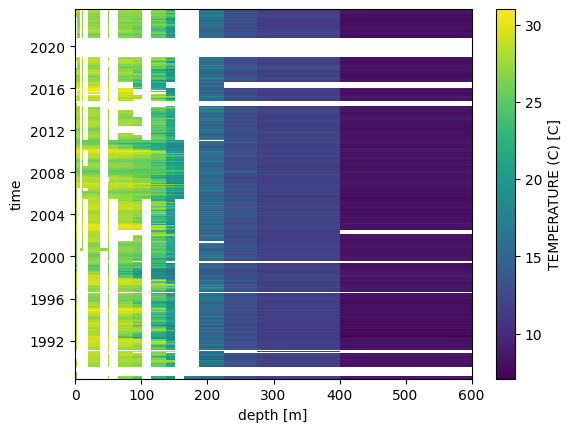

In [109]:
# Observación rápida
ds.T_20.plot() # Hay muchas profundidades con datos faltantes (vacíos)



---
# Debemos de eliminar las profundidades con menor cantidad de datos.
Para ello observaremos sus estadísticos (donde aparecerá el conteo de datos)

---

In [110]:
# Resumen estadístico con las estadísticas en orden predeterminado
conteo = ds.to_dataframe().reset_index().pivot(index='time', columns='depth', values='T_20').describe(percentiles=[0.25, 0.5, 0.75], include='all')

# Ordenar las estadísticas
# orden_estadisticas = ['count', 'mean', 'std', 'max', 'min', '25%', '50%', '75%']
orden_estadisticas = ['count', 'std', 'max', 'min']
conteo_ordenado = conteo.reindex(orden_estadisticas)
conteo_ordenado

depth,1.0,5.0,9.0,10.0,13.0,25.0,49.0,50.0,53.0,75.0,100.0,103.0,125.0,150.0,153.0,175.0,200.0,250.0,300.0,500.0
count,10277.000000,5270.000000,120.000000,7543.000000,1421.000000,11287.000000,120.000000,11031.000000,2039.000000,10671.000000,10444.000000,2039.000000,11426.000000,11342.000000,2039.000000,108.000000,11426.000000,11349.000000,11362.000000,11216.000000
std,1.222665,1.184979,0.254086,1.182001,1.304754,1.182538,0.266707,1.250506,1.337284,1.409061,1.877260,1.699532,2.346674,2.376399,1.972930,1.016525,1.193347,0.529341,0.352369,0.282019
max,30.969999,30.827959,28.000000,30.999506,30.320000,30.829180,27.900000,30.682398,30.480000,30.697933,30.459999,30.200001,30.389999,29.129999,28.040001,19.049999,24.200001,15.790000,13.113479,9.830000
min,24.090000,24.400000,27.020000,24.360001,24.400000,23.730000,26.740000,23.110001,23.850000,21.600000,18.020000,19.910000,16.549999,15.080000,15.910000,14.210000,12.760000,11.371746,10.590000,7.080000



---


# Eliminamos las profundidades con cantidad de datos menores al 70% del máximo de datos.
[5,9,13,49,53,103,153,175]

---

In [111]:
# Eliminamos las profundidades con pocos datos
profundidades_eliminar = [5,9,10,13,49,53,103,153,175]
# Eliminamos y la asignamos a la misma variable de los datos observados
ds = ds.drop_sel(depth=profundidades_eliminar)


---


 # PROMEDIO HISTÒRICO DIARIO (CLIM: 1991-01-01 - 2020-12-31)

---

In [112]:
# Calcular el promedio climatológico de cada día del año
year_inicio = 1991
year_fin = 2020
clim = ds.sel(time=slice(f'{year_inicio}-01-01', f'{year_fin}-12-31')).groupby('time.dayofyear').mean(dim='time')

---


 # CÁLCULO DE LA ANOMALÍA APARTIR DEL PROMEDIO HISTÓRICO DIARIO

---

In [113]:
# Calcular la anomalía diaria en relación al promedio climatológico de cada día del año
anom = ds.groupby('time.dayofyear') - clim
anom

<xarray.Dataset>
Dimensions:    (time: 12839, depth: 11)
Coordinates:
  * time       (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-07-10
  * depth      (depth) float32 1.0 25.0 50.0 75.0 ... 200.0 250.0 300.0 500.0
    dayofyear  (time) int64 137 138 139 140 141 142 ... 186 187 188 189 190 191
Data variables:
    T_20       (time, depth) float32 -0.8824 nan -0.6367 ... -0.2811 0.1548

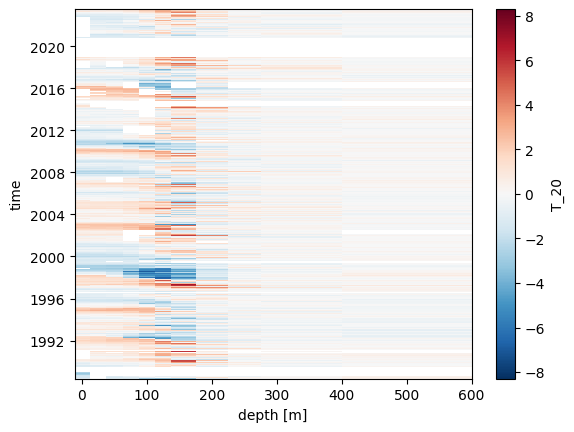

In [114]:
# Observamos que por defecto las profundidades se posicionan en el EJE X.
# Necesitamos que se posicione en el EJE Y. Además existen datos vacíos, por lo que necesitamos
# realizar una interpolación
anom.T_20.plot()

In [115]:
anom = anom.transpose('depth', 'time')
anom['T_20']

<xarray.DataArray 'T_20' (depth: 11, time: 12839)>
array([[-0.8824425 , -0.925827  , -1.0098267 , ...,  0.91557693,
         0.8588829 ,  0.8348255 ],
       [        nan,         nan,         nan, ...,  0.92881775,
         0.8916912 ,  0.9336643 ],
       [-0.6367264 , -0.9179325 , -1.0016918 , ...,  0.9925194 ,
         0.9638729 ,  0.9470463 ],
       ...,
       [-0.21539497,  0.2452097 ,  0.5194464 , ..., -0.09546757,
        -0.11210346, -0.1978426 ],
       [-0.16139984,  0.36933708,  0.22326279, ..., -0.25371552,
        -0.22963047, -0.2810955 ],
       [ 0.28419495,  0.34027576,  0.25500107, ..., -0.05233002,
         0.09599304,  0.15484238]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-07-10
  * depth      (depth) float32 1.0 25.0 50.0 75.0 ... 200.0 250.0 300.0 500.0
    dayofyear  (time) int64 137 138 139 140 141 142 ... 186 187 188 189 190 191

In [116]:
# Realizar la interpolación
anom_interp = anom.interpolate_na(dim='time')
anom_interp['T_20']

<xarray.DataArray 'T_20' (depth: 11, time: 12839)>
array([[-0.8824425 , -0.925827  , -1.0098267 , ...,  0.91557693,
         0.8588829 ,  0.8348255 ],
       [        nan,         nan,         nan, ...,  0.92881775,
         0.8916912 ,  0.9336643 ],
       [-0.6367264 , -0.9179325 , -1.0016918 , ...,  0.9925194 ,
         0.9638729 ,  0.9470463 ],
       ...,
       [-0.21539497,  0.2452097 ,  0.5194464 , ..., -0.09546757,
        -0.11210346, -0.1978426 ],
       [-0.16139984,  0.36933708,  0.22326279, ..., -0.25371552,
        -0.22963047, -0.2810955 ],
       [ 0.28419495,  0.34027576,  0.25500107, ..., -0.05233002,
         0.09599304,  0.15484238]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-07-10
  * depth      (depth) float32 1.0 25.0 50.0 75.0 ... 200.0 250.0 300.0 500.0
    dayofyear  (time) int64 137 138 139 140 141 142 ... 186 187 188 189 190 191

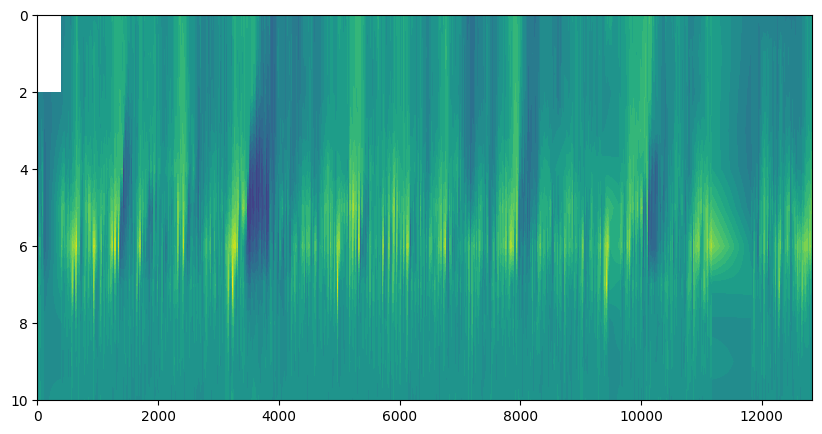

In [117]:
# DESPUÉS DE INTERPOLAR:
fig , ax = plt.subplots(figsize=(10,5))
ax.contourf(anom_interp.T_20,29);
# Invertimos el eje y
ax.invert_yaxis()

In [118]:
from scipy.ndimage import gaussian_filter
import datetime
import matplotlib.dates as mdates

def Anom(data,sigma):
  fig, ax = plt.subplots(figsize=(20, 3))
  # Obtener los datos y fechas de tu gráfica
  dates = data.time
  values = data.values
  # -----------------------------------------------------------------------------------------
  # Suavizado de contornos y countor fill
  sigma = sigma
  interp_temp_smooth = gaussian_filter(data, sigma=sigma)
  # -----------------------------------------------------------------------------------------
  # Graficar mapa de colores suavizado
  levels = np.arange(-7, 8, 1)
  cs = ax.contourf(data.time, data.depth, interp_temp_smooth, levels, cmap="RdBu_r")

  # # Definir niveles de las líneas de contorno
  black_levels = [-6,-5,-4,-3,-2,-1,1,2,3,4,5]
  grey_levels = [level for level in levels if level not in black_levels]

  # Líneas de contorno con suavizado
  cs2 = ax.contour(data.time, data.depth, interp_temp_smooth, colors='black', levels=black_levels, linewidths=0.9, linestyles='-')
  cs3 = ax.contour(data.time, data.depth, interp_temp_smooth, colors='whitesmoke', levels=grey_levels, linewidths=0.5, linestyles='-')

  # Agregar etiquetas a las líneas de contorno
  ax.clabel(cs2, fmt='%2.1f', colors='black', fontsize=12)
  # -----------------------------------------------------------------------------------------
    # Invertir el eje y y establecer límites y escala del eje y
  ax.invert_yaxis()
  ax.set_ylim(300, 0)
  ax.set_yticks(range(0, 301, 50)) # Hasta 300m de profundidad
  # -----------------------------------------------------------------------------------------
  # Agregar etiquetas de valores en la barra de colores
  cbar = fig.colorbar(cs, ax=ax, ticks=np.arange(-7, 8))
  cbar.outline.set_linewidth(1)
  cbar.ax.tick_params(labelsize=8)
  # cbar.ax.set_yticklabels(['{:.0f}'.format(i) for i in np.arange(-7, 8)])
  cbar.ax.set_position([0.755, 0.1, 5, 0.8])  # [left, bottom, width, height]
  # -----------------------------------------------------------------------------------------
  # ESTILO :V
  ax.set_title(f'Anomalías de Temperatura [°C] Sub Superficial del mar, Años: {year} - {next_year}',
               style="oblique", fontsize=10, color = 'black')
  # ax.set_title(f'Anomalía de Temperatura [°C] Sub Superficial del mar\nAños: {year},  Boya: 0N 170W', fontsize=20, color = 'black')
  ax.xaxis.label.set_color('black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(colors='black')

  plt.xticks(fontsize = 8,  style="oblique")
  plt.yticks(fontsize = 8,  style="oblique")
  ax.set_xlabel('')

  ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
  plt.xticks()
  plt.xticks(rotation=10)

  plt.text(0, -0.18, 'Fuente de datos: NOAA [TAO/TRITON]',  style="oblique", fontsize=8, ha='left',
        va='center', color='black', transform=plt.gca().transAxes)
  #-----------------------------------------------------------------------------------------
  fig.savefig(path + f'AnomTempSub{year} - {next_year}.jpg',
                  transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')
  plt.show()
  plt.close()

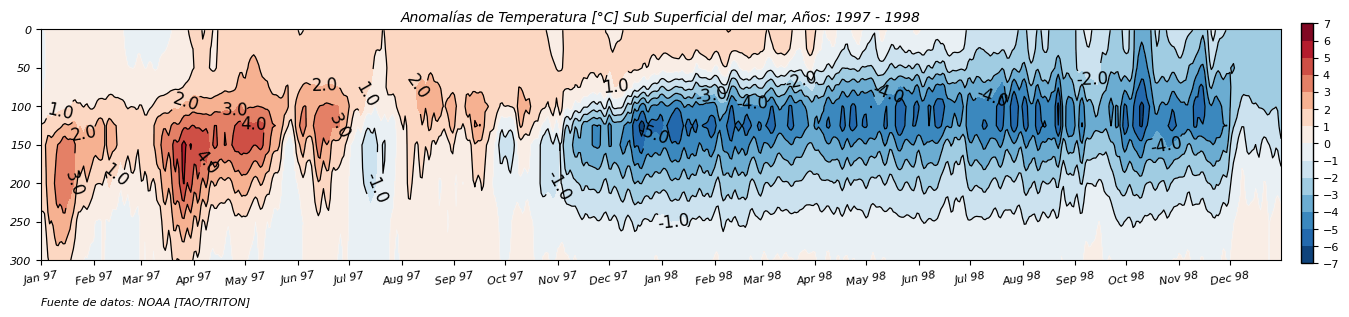

In [119]:
years = [1997,1998]
for i in range(len(years)-1):
  year = years[i]
  next_year = years[i+1]
  years_unidosxd = anom_interp.T_20.sel(time=slice(f'{year}-01-01', f'{next_year}-12-31'))
  Anom(years_unidosxd,0.9) # Ajustar el suavizado (valores mayores a 0)

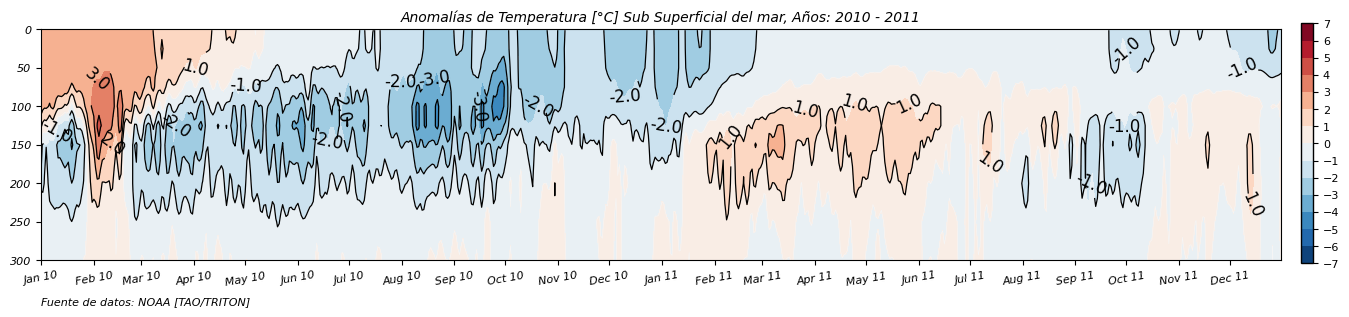

In [120]:
years = [2010,2011]
for i in range(len(years)-1):
  year = years[i]
  next_year = years[i+1]
  years_unidosxd = anom_interp.T_20.sel(time=slice(f'{year}-01-01', f'{next_year}-12-31'))
  Anom(years_unidosxd,0.85) # Ajustar el suavizado (valores mayores a 0)

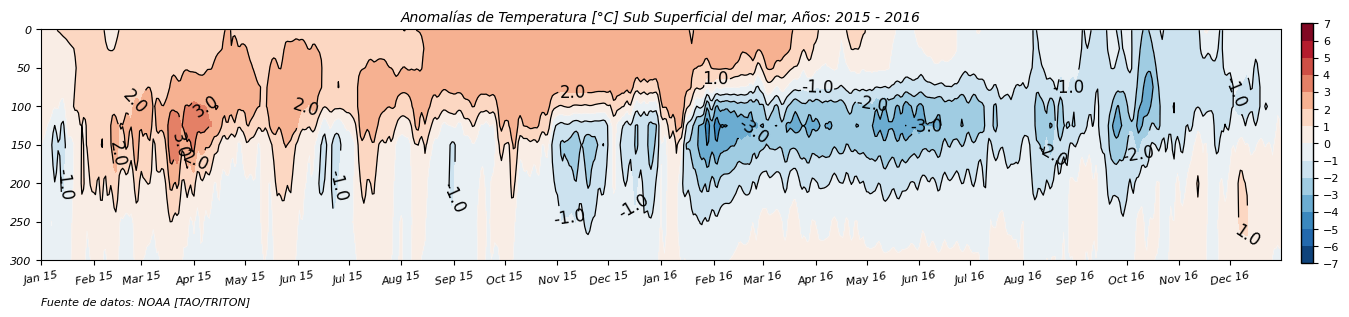

In [121]:
years = [2015,2016]
for i in range(len(years)-1):
  year = years[i]
  next_year = years[i+1]
  years_unidosxd = anom_interp.T_20.sel(time=slice(f'{year}-01-01', f'{next_year}-12-31'))
  Anom(years_unidosxd,0.85) # Ajustar el suavizado (valores mayores a 0)

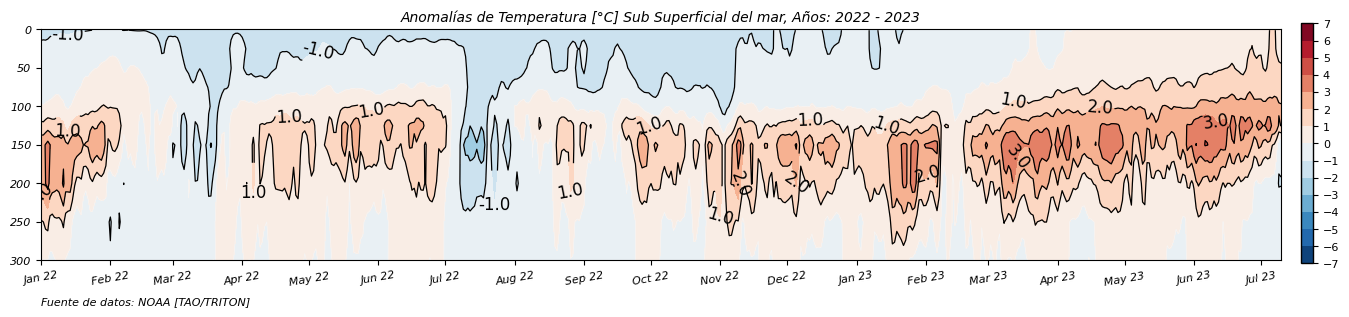

In [122]:
years = [2022,2023]
for i in range(len(years)-1):
  year = years[i]
  next_year = years[i+1]
  years_unidosxd = anom_interp.T_20.sel(time=slice(f'{year}-01-01', f'{next_year}-12-31'))
  Anom(years_unidosxd,0.65) # Ajustar el suavizado (valores mayores a 0)



---
# Los datos utilizados se encuentran en el siguiente link:
https://drive.google.com/drive/folders/1zo4Uq3XS9KKn_I2Ei1J_FiYu4QryQnNt




---

